# Question 1
Identify protein features that allow distinguishing physiological from non-physiological
dimers, and provide your opinions on their biological relevance and structural context.
Support your conclusions with figures or calculations obtained during the analysis.


## Personal notes

**Important points:**
- Crystal structures may be obtained under conditions that do not represent the physiological state, leading to assemblies that are not biologically relevant.
  (Is this what we are referring to as non-physiological dimers?)
- Proteins often form contacts whose sole function is to stabilize the crystal lattice.
  Determining which of these contacts are physiologically meaningful can be challenging.
  (Perhaps identifying such key contacts is itself an important feature.)
- Methods to evaluate the interface:
  - **PISA**: chemical and structural properties of interfaces.
  - **EPPIC**: geometric measures and sequence conservation.
- **Open question:** How should a non-physiological binding mode be defined?
- Consider scoring functions to evaluate binding interfaces.
- Check the Docking Benchmark dataset.
- In this dataset, the definition of a physiological dimer relies on conservation of the 3D structure of the interface (ProtCID and QSalign).
- **Important:** On average, physiological dimers engage in higher-affinity interactions than their non-physiological counterparts, a property highly correlated with interface area.
  (Note: in this dataset, only non-physiological complexes with interface areas similar to or larger than those of physiological dimers were included, so this feature may be less relevant here.)

In [8]:
#To facilitate, all imports are here:
import pandas as pd
import math
from scipy.stats import ttest_ind
import os
from Bio import PDB
#from pymol import cmd
from matplotlib import pyplot as plt
import glob
import numpy as np

#all sklearn imports

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

#all tensorflow imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Concatenate, Dense, Dropout, Bidirectional, LSTM, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import ops as K
import keras
from tensorflow.keras.utils import plot_model



To start this analysis, I will examine the distributions of the features.
I initially considered calculating a p-value to estimate the significance of the differences,
but the separation appears quite clear just by visual inspection.

I also performed a small literature review on the methods and features, which I will discuss later in this document.

I wrote a basic function that plots a histogram for every single feature column,
separating physiological from non-physiological cases.
I added a t-test, but it does not seem appropriate in this context.

In [21]:
def plot_histograms_by_physiological(df, bins=30, alpha=0.5, ncols=3):

    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    for col in ["Unnamed: 0", "physiological"]:
        if col in numeric_cols:
            numeric_cols.remove(col)
    labels = pd.unique(df["physiological"])
    group1, group2 = labels
    n_features = len(numeric_cols)
    nrows = math.ceil(n_features / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    for i, col in enumerate(numeric_cols):
        ax = axes[i]

        vals1 = df[df["physiological"] == group1][col].dropna()
        vals2 = df[df["physiological"] == group2][col].dropna()

        stat, p = ttest_ind(vals1, vals2, equal_var=False)
        for lab in labels:
            subset = df[df["physiological"] == lab][col].dropna()
            if subset.empty:
                continue
            ax.hist(subset, bins=bins, alpha=alpha, label=f"physiological={lab}")
        ax.set_title(col, fontsize=10)
        ax.text(0.5, -0.25, f"p_value = {p:.2e}", ha="center", va="center",
                transform=ax.transAxes, fontsize=9)
        ax.set_xlabel(col)
        ax.set_ylabel("Frequency")
        ax.legend(fontsize=8)
    for j in range(len(numeric_cols), len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()




Plotting the histograms:

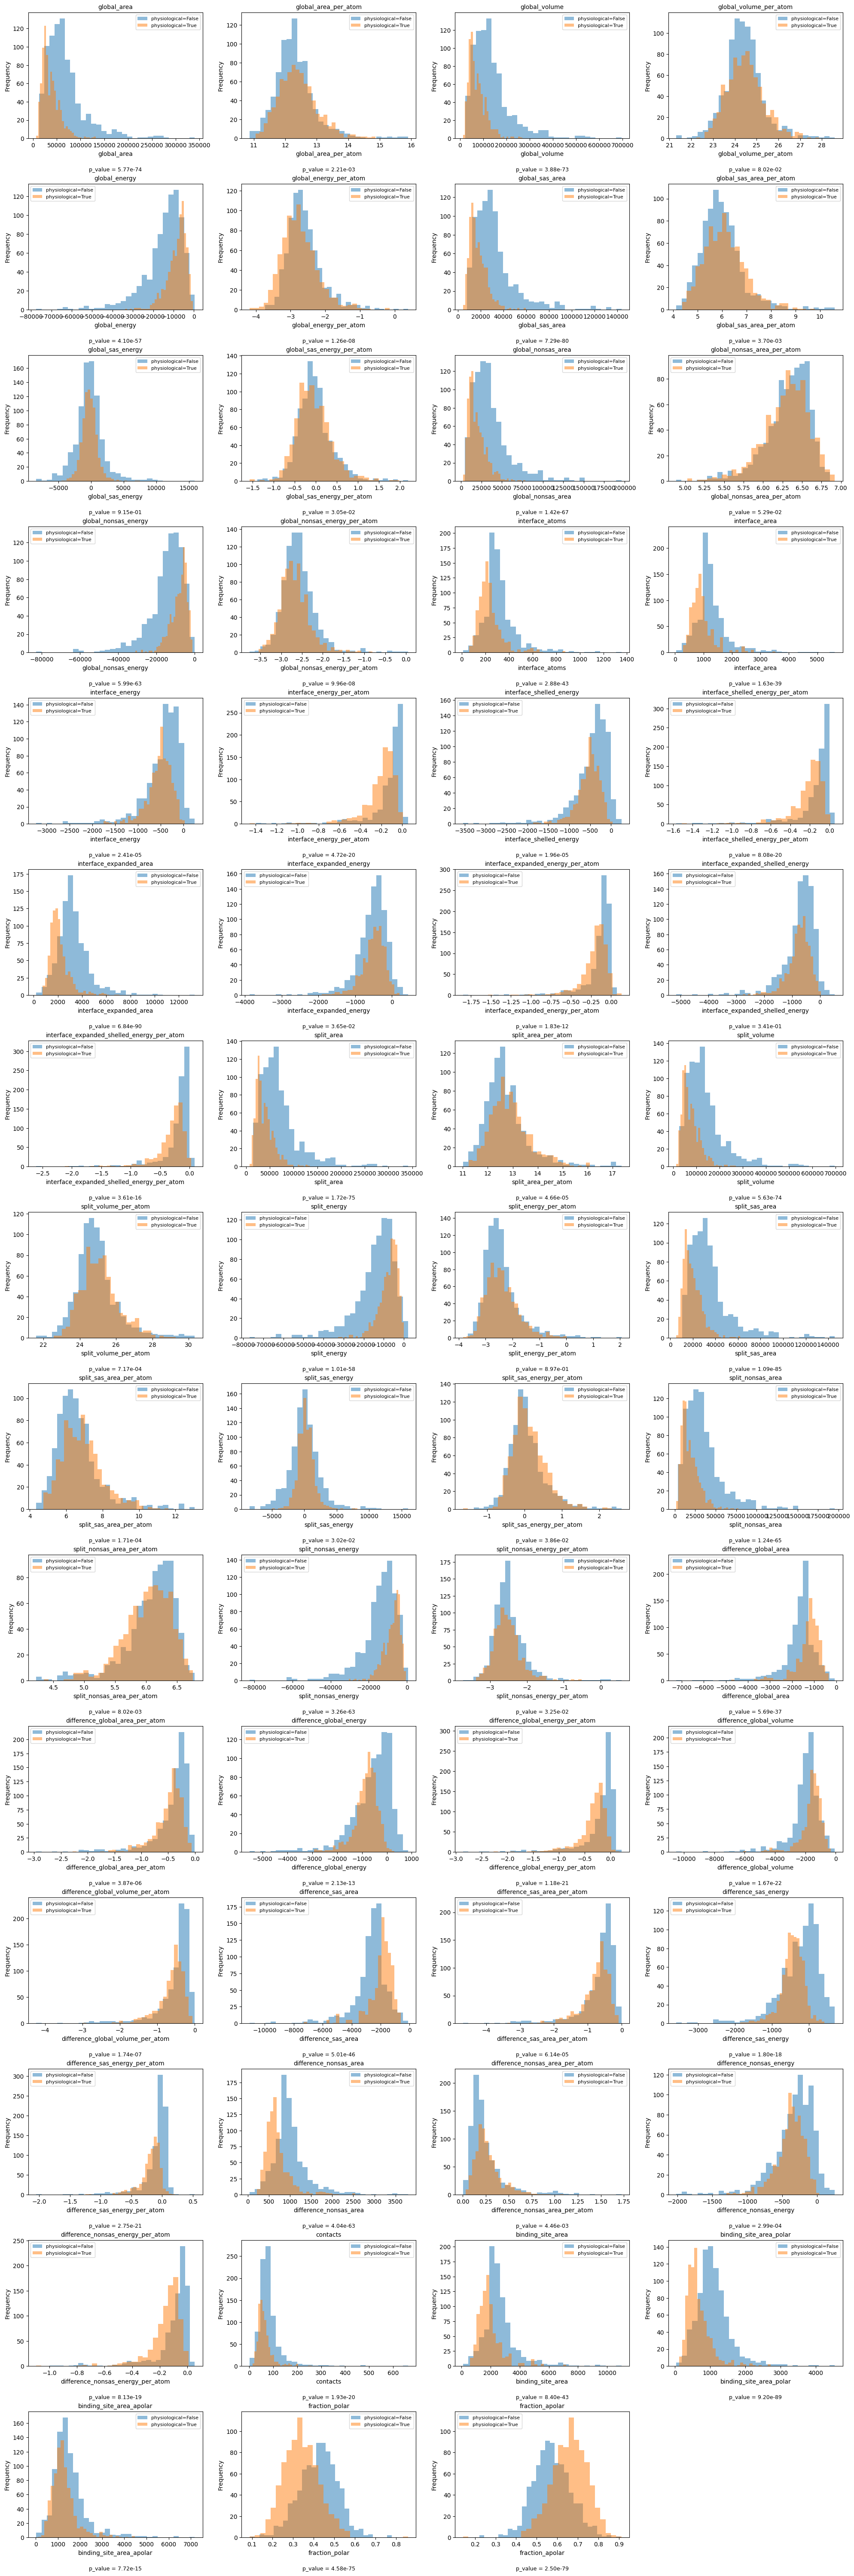

In [22]:
df = pd.read_csv("Features.csv")
plot_histograms_by_physiological(df, ncols=4)

## General observations about the distributions of the features

Starting the analysis with Global and Split features:

**global_area_per_atom, global_volume, global_volume_per_atom, global_energy, global_energy_per_atom, global_sas_area, global_sas_area_per_atom, global_sas_energy, global_sas_energy_per_atom, global_nonsas_area, global_nonsas_area_per_atom, global_nonsas_energy, global_nonsas_energy_per_atom**

**split_area, split_area_per_atom, split_volume, split_volume_per_atom, split_energy, split_energy_per_atom, split_sas_area, split_sas_area_per_atom, split_sas_energy, split_sas_energy_per_atom, split_nonsas_area, split_nonsas_area_per_atom, split_nonsas_energy, split_nonsas_energy_per_atom**

When constructing the dataset, the authors explicitly selected non-physiological structures with larger interface areas to increase the difficulty of the classification task.
On their own, these features should not be decisive. If they appear to drive classification, this is likely an artifact of the dataset rather than something biologically meaningful. In reality, whether two proteins interact in a specific binding mode should not depend primarily on the overall size of the proteins or their complexes.

Once normalized by the number of atoms, these global and split variables show essentially the same distribution for physiological and non-physiological dimers.
This strongly indicates that the observed differences in the raw distributions are mainly due to the size of the complexes and their interfaces, rather than intrinsic distinguishing features of physiological versus non-physiological binding.

---

### Interface features

**interface_atoms, interface_area, interface_energy, interface_energy_per_atom, interface_shelled_energy, interface_shelled_energy_per_atom, interface_expanded_area, interface_expanded_energy, interface_expanded_energy_per_atom, interface_expanded_shelled_energy, interface_expanded_shelled_energy_per_atom**

These variables are also strongly dependent on the size of the interface, which was artificially selected during dataset construction.
As with the global features, most of these metrics do not show meaningful differences between physiological and non-physiological dimers once normalized.

The only exception is **interface_shelled_energy_per_atom**, which shows a distinguishable difference in its distributions.
This suggests that, when corrected for interface size, the local energetic environment captured by this feature may genuinely discriminate between physiological and non-physiological dimers.

---

### Difference features

**difference_global_area, difference_global_area_per_atom, difference_global_energy, difference_global_energy_per_atom, difference_global_volume, difference_global_volume_per_atom, difference_sas_area, difference_sas_area_per_atom, difference_sas_energy, difference_sas_energy_per_atom, difference_nonsas_area, difference_nonsas_area_per_atom, difference_nonsas_energy, difference_nonsas_energy_per_atom**

Since the size selection affects both the global and split features in equivalent ways, the difference features are expected to be less biased by system size.
In practice, these variables represent the actual contribution of the interface rather than reflecting the total dimensions of the complex.

Among these, the feature **difference_sas_area_per_atom** shows a particularly interesting distribution between physiological and non-physiological dimers.
This suggests that the extent of solvent-accessible surface area buried in the interface is a meaningful discriminator.
In this case, physiological dimers tend to bury proportionally more SAS at the interface, consistent with the formation of a stable hydrophobic core.

**Quick literature support (superficial review):**

- https://pubmed.ncbi.nlm.nih.gov/28729757/ Nilofer et al., 2017: They concluded that van der Waals interactions are the dominant and proportional force at protein–protein interfaces, contributing on average ~75% of the binding energy (in this case for heterodimers), reinforcing the idea that stable physiological dimers bury more solvent-accessible surface.

---

### Other variables

**binding_site_area, binding_site_area_polar, binding_site_area_apolar, fraction_polar, fraction_apolar**

The fractions (polar and apolar) are particularly interesting because they relate directly to SAS decomposition and show clear separation in the distributions.
A higher apolar fraction promotes desolvation and van der Waals contacts, which explains why physiological complexes tend to have a lower polar fraction and a smaller polar area at the binding site.

I will explore this feature further by analyzing the nature and energy of the contacts in the interface using the **Surfaces** Python script:
https://academic.oup.com/bioinformatics/article/39/10/btad608/7288175?login=false

This script generates a list of contacts between pairs of amino acid residues, saved in a `.txt` file with the following format:



# Problems with the dataset:

Before proceeding with the analysis: Even though in the main document it is announced that data sets are ready to use and doesn't require any pre-treatment. I found a couple of structures that were not right at all:

->7 structures have more than 2 chains and look very wierd I selected a couple of photos of it:
(more than two chains: 1ujk_3, 2axi_3, 1f1j_5, 3hna_3, 1lvb_5, 1lvl_4, 4tt4_1)


<img src="images/2axi_3.png" alt="2axi_3" width="200"/>

-> Also, some steric clashes also are visible in some structures (I wont proceed with a sterical clashes check, but this should be pointed out) note: Should check for clashes be also a feature???:

<img src="images/5yii_1.png" alt="5yii_1" width="200"/>

-> Moreover, a clear mistake in generating the .pdb files is that 300 structures have duplicated atom numbers (atom numbering re-start from 1 in the other chain), it shouldn't cause errors, but it is not a proper pdb formating, so I fixed it using pymol: see the exemple: "./images/3e7p_1.pdb"

<img src="images/wrong_numbering.png" alt="wrong_numbering" width="200"/>


# Running surfaces to the dataset excluding the 7 structures with more than two chains, correcting numbering, but not checking for clashes:


In [2]:
pdb_list=os.listdir("01_PDB_legacy_3dcomplex_expanded")
count=0
final_set=[]
for pdb in pdb_list:
    if "clean.pdb" in pdb:
        parser = PDB.PDBParser(QUIET=True)
        structure = parser.get_structure("structure", f"01_PDB_legacy_3dcomplex_expanded/{pdb}")

        chain_ids = set()
        for model in structure:
            for chain in model:
                chain_ids.add(chain.id)
            chain_ids = list(chain_ids)
            if len(chain_ids)>2 or len(chain_ids)<=1:
                print(f"More than two chain IDs found: {pdb} ->", ", ".join(sorted(chain_ids)))
            else:
                # I used pymol to correct the pdb files with duplicated atom numbers:
                #cmd.load(f"01_PDB_legacy_3dcomplex_expanded/{pdb}")
                #cmd.save("01_PDB_legacy_3dcomplex_expanded/"+pdb,pdb[:-4])
                os.system(f"python Surfaces/surface_cont.py -f 01_PDB_legacy_3dcomplex_expanded/{pdb} -c1 {chain_ids[0]} -c2 {chain_ids[1]} -o Surfaces_results/{pdb[:-4]}_output.csv -def Surfaces/AMINO_FlexAID.def -dat Surfaces/FlexAID.dat")
                final_set.append(pdb[:-4])
                count+=1
                print(pdb[:-10],count)



NameError: name 'os' is not defined

# Analyzing the contacts data

I created a dictionary with the type of each residue and classified the interactions into the following categories:
- **hydrophobic**
- **polar**
- **charged_same** (interactions between residues with the same charge)
- **charged_opposite** (interactions between residues with opposite charges)
- **polar-hydrophobic**
- **charged_mix** (charged with either polar or hydrophobic)

In addition, I counted the number of **favorable contacts** (negative energy) and **unfavorable contacts** (positive energy) within each interface.

In [38]:
hydrophobic = {"VAL", "ILE", "LEU", "ALA", "PHE", "TRP", "MET", "PRO", "TYR"}
polar = {"SER", "THR", "ASN", "GLN", "HIS", "TYR", "CYS"}
charged_pos = {"LYS", "ARG", "HIS"}
charged_neg = {"ASP", "GLU"}

def classify_interaction(res1, res2):
    r1, r2 = res1[:3], res2[:3]
    if r1 in hydrophobic and r2 in hydrophobic:
        return "hydrophobic"
    if r1 in polar and r2 in polar:
        return "polar"
    if (r1 in charged_pos and r2 in charged_pos) or (r1 in charged_neg and r2 in charged_neg):
        return "charged_same"
    if (r1 in charged_pos and r2 in charged_neg) or (r1 in charged_neg and r2 in charged_pos):
        return "charged_opposite"
    if (r1 in polar and r2 in hydrophobic) or (r2 in polar and r1 in hydrophobic):
        return "polar-hydrophobic"
    if ((r1 in charged_pos | charged_neg) and (r2 in polar | hydrophobic)) or \
       ((r2 in charged_pos | charged_neg) and (r1 in polar | hydrophobic)):
        return "charged-mixed"
    return "other"

def extract_features(file_path):
    df = pd.read_csv(file_path, header=None, names=["res1", "res2", "energy"])

    unfavorable = (df["energy"] > 0).sum()
    favorable = (df["energy"] <= 0).sum()

    df["interaction_type"] = df.apply(lambda r: classify_interaction(r["res1"], r["res2"]), axis=1)
    counts = df["interaction_type"].value_counts().to_dict()

    categories = ["hydrophobic", "polar", "charged_same", "charged_opposite", "polar-hydrophobic", "charged-mixed", "other"]
    for cat in categories:
        counts.setdefault(cat, 0)

    total = favorable + unfavorable
    frac_fav = favorable / total if total > 0 else 0
    frac_unfav = unfavorable / total if total > 0 else 0

    features = {
        "file": os.path.basename(file_path),
        "favorable_interactions": int(favorable),
        "unfavorable_interactions": int(unfavorable),
        "fraction_favorable": frac_fav,
        "fraction_unfavorable": frac_unfav,
        **counts
    }
    return features

def process_directory(input_dir, output_csv="features_summary.csv"):
    all_files = glob.glob(os.path.join(input_dir, "*_list.txt"))
    results = []
    for f in all_files:
        results.append(extract_features(f))
    df_out = pd.DataFrame(results)
    df_out.to_csv(output_csv, index=False)
    print(f"Saved summary to {output_csv}")

process_directory("Surfaces_results", "contact_features.csv")



Saved summary to contact_features.csv


# Looking at the distributions and merging with original features

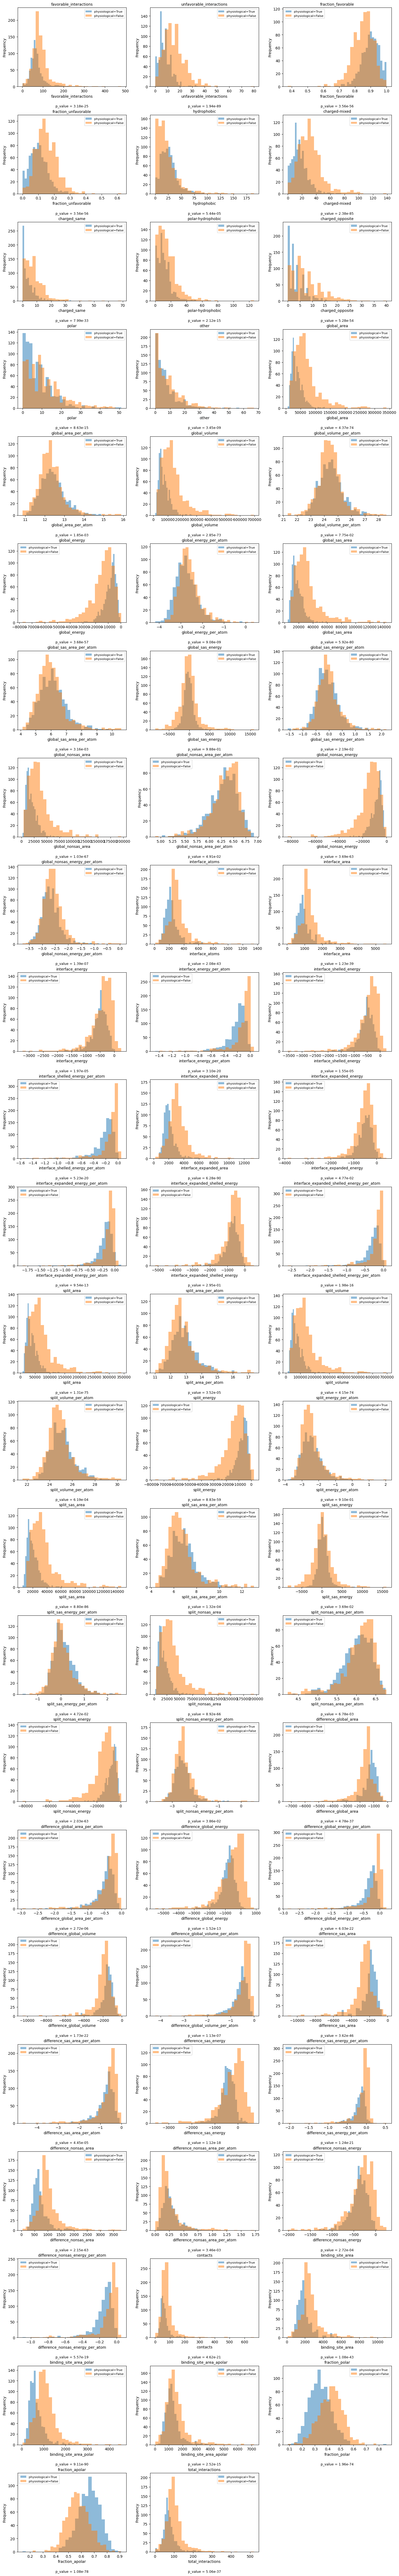

Saved: combined_contact_features.csv


,file,favorable_interactions,unfavorable_interactions,fraction_favorable,fraction_unfavorable,hydrophobic,charged-mixed,charged_same,polar-hydrophobic,charged_opposite,...,difference_nonsas_energy,difference_nonsas_energy_per_atom,contacts,binding_site_area,binding_site_area_polar,binding_site_area_apolar,fraction_polar,fraction_apolar,difficult,total_interactions
0,3lyn_1_clean_output_list.txt,63,3,0.954545,0.045455,27,24,5,4,2,...,-457.36228,-0.22310,40,1833.49,763.21,1070.27,0.416261,0.583734,False,66
1,2ym0_5_clean_output_list.txt,69,11,0.862500,0.137500,35,18,2,17,2,...,-464.22800,-0.15146,64,2283.83,627.10,1656.74,0.274583,0.725422,False,80
2,1yad_2_clean_output_list.txt,64,3,0.955224,0.044776,23,15,4,13,2,...,-297.77800,-0.10170,48,1558.97,456.39,1102.59,0.292751,0.707255,False,67
3,1k6i_3_clean_output_list.txt,69,10,0.873418,0.126582,25,25,10,4,10,...,-428.75700,-0.08473,64,2100.95,916.45,1184.49,0.436207,0.563788,False,79
4,2qlx_2_clean_output_list.txt,110,13,0.894309,0.105691,37,32,6,27,10,...,-664.21700,-0.41001,104,2992.70,1125.41,1867.29,0.376052,0.623948,False,123


In [33]:
contact_features_path = "contact_features.csv"
labels_path = "Features.csv"
output_path = "combined_contact_features.csv"


cf = pd.read_csv(contact_features_path)
labels = pd.read_csv(labels_path)

def to_pdbid(fname: str) -> str:
    base = os.path.basename(fname)
    return base.replace("_clean_output_list.txt", "")

cf["pdb-id"] = cf["file"].apply(to_pdbid)

columns_to_keep = ["pdb-id", "physiological"]
extra_numeric = [c for c in labels.columns if c not in columns_to_keep and pd.api.types.is_numeric_dtype(labels[c])]

labels_trim = labels[columns_to_keep + extra_numeric]

merged = cf.merge(labels_trim, on="pdb-id", how="left")

if {"unfavorable_interactions", "favorable_interactions"}.issubset(merged.columns):
    merged["total_interactions"] = (merged["unfavorable_interactions"].fillna(0) + merged["favorable_interactions"].fillna(0) )

if merged["physiological"].dtype == object:
    merged["physiological"] = merged["physiological"].str.strip().map( {"physiological": True, "non-physiological": False} )


plot_histograms_by_physiological(merged, bins=30, alpha=0.5, ncols=3)

merged.to_csv(output_path, index=False)
print(f"Saved: {output_path}")

merged.head()

Looking at the results of the energy decomposition and the nature of the contacts at the interface:

The most notable difference is in the distribution of favorable and unfavorable interactions.
A larger fraction of unfavorable interactions is observed in the non-physiological complexes,
indicating the presence of more frustrated residues at their interfaces.

It is also possible to observe a higher prevalence of hydrophobic contacts in the interfaces of physiological dimers,
which is consistent with the trends observed in the original feature analysis.

Next, we will gain further insights into the complex relationships between these features by training
a simple regression model and a random forest model, followed by a feature importance analysis.

# Training a Regression and Random Forest model on the feature dataset (including the new contact features)


In [34]:
df=pd.read_csv("combined_contact_features.csv")

drop=["physiological", "file", "pdb-id", "Unnamed: 0","difficult","interface_expanded_area","difficult"]

for col in df.columns:
    if "global" in col or "split" in col:
        drop.append(col)


X = df.drop(columns=drop)
y = df["physiological"].astype(int)

#is the data set balanced??
print(df.loc[df.physiological==0,].shape[0], df.loc[df.physiological!=0,].shape[0])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#Random forest

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

#LogisticRegression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_scaled, y_train)


y_pred_lr = log_reg.predict(X_test_scaled)


835 835


## Evaluating the performance of the model:

In [35]:
#Model evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f" Accuracy: RF {accuracy_rf}, LR {accuracy_lr}")


#Confusion matrixes:

cm_rf=confusion_matrix(y_test, y_pred_rf)
cm_lr=confusion_matrix(y_test, y_pred_lr)

print("Confusion Matrix_rf \n", cm_rf)
print("Confusion_Matrix_lr \n", cm_lr)

#false discovery rates:
def fdr(cm):
    TN, FP, FN, TP = cm.ravel()

    if (TP+FP) > 0:

        fdr = FP/(TP+FP)

    else:

        fdr = 0.0
    return fdr

fdr_rf=fdr(cm_rf)
fdr_lr=fdr(cm_lr)

print(f"FDR RF:{fdr_rf}\n")
print(f"FDR LR:{fdr_lr}\n")


#make report:
report_rf = classification_report(y_test, y_pred_rf)
report_lr = classification_report(y_test, y_pred_lr)

print("Report RF:\n",report_rf)
print("Report LR:\n", report_lr)

 Accuracy: RF 0.8592814371257484, LR 0.8383233532934131
Confusion Matrix_rf 
 [[146  21]
 [ 26 141]]
Confusion_Matrix_lr 
 [[137  30]
 [ 24 143]]
FDR RF:0.12962962962962962

FDR LR:0.17341040462427745

Report RF:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86       167
           1       0.87      0.84      0.86       167

    accuracy                           0.86       334
   macro avg       0.86      0.86      0.86       334
weighted avg       0.86      0.86      0.86       334

Report LR:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84       167
           1       0.83      0.86      0.84       167

    accuracy                           0.84       334
   macro avg       0.84      0.84      0.84       334
weighted avg       0.84      0.84      0.84       334



In [36]:
importances_rf = rf.feature_importances_


print("Feature Importances RF:\n", pd.DataFrame({"Features":X.columns.tolist(),"Importance":importances_rf}).sort_values(by="Importance", ascending=False).reset_index(drop=True))

importances_lr = log_reg.coef_[0]

feature_importances_lr = (
    pd.DataFrame({
        "Features": X.columns.tolist(),
        "Coefficient": importances_lr,
        "Abs_Importance": abs(importances_lr)
    })
    .sort_values(by="Abs_Importance", ascending=False)
    .reset_index(drop=True)
)

print("Feature Importances (Logistic Regression):\n", feature_importances_lr)


Feature Importances RF:
                                       Features  Importance
0                       difference_nonsas_area    0.101958
1                      binding_site_area_polar    0.069721
2                    interface_energy_per_atom    0.067267
3            interface_shelled_energy_per_atom    0.065322
4                          difference_sas_area    0.048427
5               difference_sas_energy_per_atom    0.045126
6                                charged-mixed    0.038598
7                            binding_site_area    0.038202
8            difference_nonsas_energy_per_atom    0.033783
9   interface_expanded_shelled_energy_per_atom    0.030270
10                             interface_atoms    0.029846
11                       difference_sas_energy    0.029348
12                              interface_area    0.027597
13                    interface_shelled_energy    0.026809
14                             fraction_apolar    0.025869
15                            i

In [37]:
r = permutation_importance(rf, X_test, y_test,
                           n_repeats=30)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns.tolist()[i]: <8}"
              f"{r.importances_mean[i]: .3f}"
              f" +/- {r.importances_std[i]: .3f}")

difference_nonsas_area 0.046 +/-  0.012
hydrophobic 0.014 +/-  0.005
difference_sas_area 0.010 +/-  0.004


# General conclusions

Both models performed well in distinguishing physiological from non-physiological complexes,
with overall accuracies of **0.86 (RF)** and **0.84 (LR)**.
The confusion matrices and classification reports confirm that both approaches balance precision and recall across classes,
though the Random Forest consistently achieves slightly higher F1-scores and a lower False Discovery Rate
(**FDR: 0.13 vs. 0.17**), indicating greater reliability.

From a feature perspective, the Random Forest highlights structural and energetic descriptors such as:
- difference in non-surface area,
- binding site area (polar),
- interface energy per atom.

These results underscore the relevance of both **surface accessibility** and **energetic balance** in determining physiological interactions.

In contrast, Logistic Regression emphasizes similar trends but provides complementary insights,
with strong weights for:
- difference in non-surface area,
- binding site area (polar/apolar),
- fraction apolar.

This reinforces the importance of **solvent accessibility**, **polarity**, and **energetic descriptors**
as central determinants of dimer stability.


# Making a fancier model

I decided to try a basic sequence-based deep learning approach for PPI classification,
using the contact energy matrix we calculated for each complex with the **Surfaces** script in the previous steps.

The model is **BiLSTM-based**. I got the idea while testing with a colleague on a similar PPI-prediction project.
She gave me some hints about the architecture she used, and I developed my own version based on our discussions.

The model takes **3 vectors** as input, representing the contacts at the interface:
1. residues in one chain
2. residues in the other chain
3. energy calculated with Surfaces

The output is binary:
- `1 = physiological`
- `0 = non-physiological`

For embeddings, I used a generic setup suggested by ChatGPT.
For the model parameters, I tried a few different combinations (without following a systematic methodology)
until I got something with better accuracy than random… but I couldn’t make it outperform RF or LR. :/

Given that I didn’t have much time, this model wasn’t well planned and the final architecture resulted from a **trial-and-error approach**.

---

### Notes for future me (useful material for improving this model)
- Video on basic concepts: https://www.youtube.com/watch?v=atYPhweJ7ao
- Article: https://www.sciencedirect.com/science/article/pii/S0010482524015348#sec7


## Preprocessing

- **Residue encoding:**
  Residues are identified by three-letter codes (ALA, LYS, etc.).
  I collected all residues across all files, converted them to lowercase, and mapped each residue type to an integer.
  Note: added `+1` so that `0` is reserved for padding (since the vectors have different sizes).

- **Energy scaling:**
  Concatenated the energy values and scaled them to the range `[-1, 1]`.

- **Padding:**
  Applied to ensure equal sequence lengths across complexes.

- **Labels:**
  `1 = physiological`
  `0 = non-physiological`


In [16]:
keras.utils.set_random_seed(42)

def encode_series(s: pd.Series) -> np.ndarray:

    return encoder.transform(s.str[:3].str.lower()) + 1

def extract_id(path: str) -> str:
    base = os.path.basename(path)
    parts = base.split("_")
    return "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

contact_files = sorted(glob.glob("Surfaces_results/*_list.txt"))

all_data = []
for path in contact_files:
    df = pd.read_csv(path, header=None, names=["res1","res2","energy"])
    all_data.append(df)

all_residues = (pd.concat(all_data)[["res1","res2"]].stack().str[:3].str.lower().unique())
encoder = LabelEncoder().fit(all_residues)


all_energy = np.concatenate([d["energy"].values for d in all_data])
scaler = StandardScaler().fit(all_energy.reshape(-1, 1))

# Pad sequences to the same length
max_len = max(len(df) for df in all_data)
r1_list, r2_list, en_list = [], [], []
for d in all_data:
    r1_list.append(encode_series(d["res1"]).astype("int32"))
    r2_list.append(encode_series(d["res2"]).astype("int32"))
    en_scaled = scaler.transform(d["energy"].values.reshape(-1,1)).ravel().astype("float32")
    en_list.append(en_scaled)

r1_pad = pad_sequences(r1_list, maxlen=max_len, padding="post", truncating="post", value=0)
r2_pad = pad_sequences(r2_list, maxlen=max_len, padding="post", truncating="post", value=0)
en_pad = pad_sequences(en_list, maxlen=max_len, padding="post", truncating="post", value=0.0).astype("float32")

# Labelling
labels = pd.read_csv("Features.csv")
id_map = dict(zip(labels["pdb-id"].astype(str), labels["physiological"].astype(int)))

ids = [extract_id(p) for p in contact_files]
missing = [i for i in ids if i not in id_map]

y = np.array([id_map[i] for i in ids], dtype="float32")

# Train/Test split:

normal: 5 fold cv

In [17]:
idx_all = np.arange(len(y))

# 20% test
idx_train, idx_test = train_test_split(idx_all, test_size=0.20, random_state=42, stratify=y)

# For the rest: 80% train 20% as val
idx_train, idx_val = train_test_split(idx_train, test_size=0.20, random_state=42, stratify=y[idx_train])

r1_tr, r1_va, r1_te = r1_pad[idx_train], r1_pad[idx_val], r1_pad[idx_test]
r2_tr, r2_va, r2_te = r2_pad[idx_train], r2_pad[idx_val], r2_pad[idx_test]
en_tr, en_va, en_te = en_pad[idx_train], en_pad[idx_val], en_pad[idx_test]
y_tr,  y_va,  y_te  = y[idx_train],    y[idx_val],    y[idx_test]

print("train:", len(y_tr), "val:", len(y_va), "test:", len(y_te))

train: 1068 val: 268 test: 334


# The model:







In [18]:
max_len = r1_pad.shape[1]
vocab_size = len(encoder.classes_)+1
emb_dim=32

#inputs
r1_in=Input(shape=(max_len,), dtype="int32", name="r1")
r2_in=Input(shape=(max_len,), dtype="int32", name="r2")
en_in=Input(shape=(max_len, 1), dtype="float32", name="en")

#embeddings and mask... note: mask for avoid using zeros as variables and introducing noise
emb=Embedding(vocab_size, emb_dim, mask_zero=True, name="res_embedding")
r1_e=emb(r1_in)
r2_e=emb(r2_in)

pair_e=Concatenate(axis=-1, name="pair_concat")([r1_e, r2_e])
pair=Concatenate(axis=-1, name="add_energy")([pair_e, en_in])

seq_mask=Lambda(lambda t: K.not_equal(t, 0), name="seq_mask")(r1_in)

# Layers:
h = Bidirectional(LSTM(64, dropout=0.25, return_sequences=False),name="bilstm")(pair, mask=seq_mask)

h=Dropout(0.4, name="head_dropout")(h)
h=Dense(64, activation="relu", name="fc1")(h)
h=Dropout(0.3, name="head_dropout2")(h)
out=Dense(1, activation="sigmoid", name="out")(h)

model = Model(inputs=[r1_in, r2_in, en_in], outputs=out)
model.compile(optimizer=Adam(learning_rate=1e-4),loss="binary_crossentropy",metrics=[AUC(name="auc"), "accuracy"])

# Lets take a look at the model final structure:

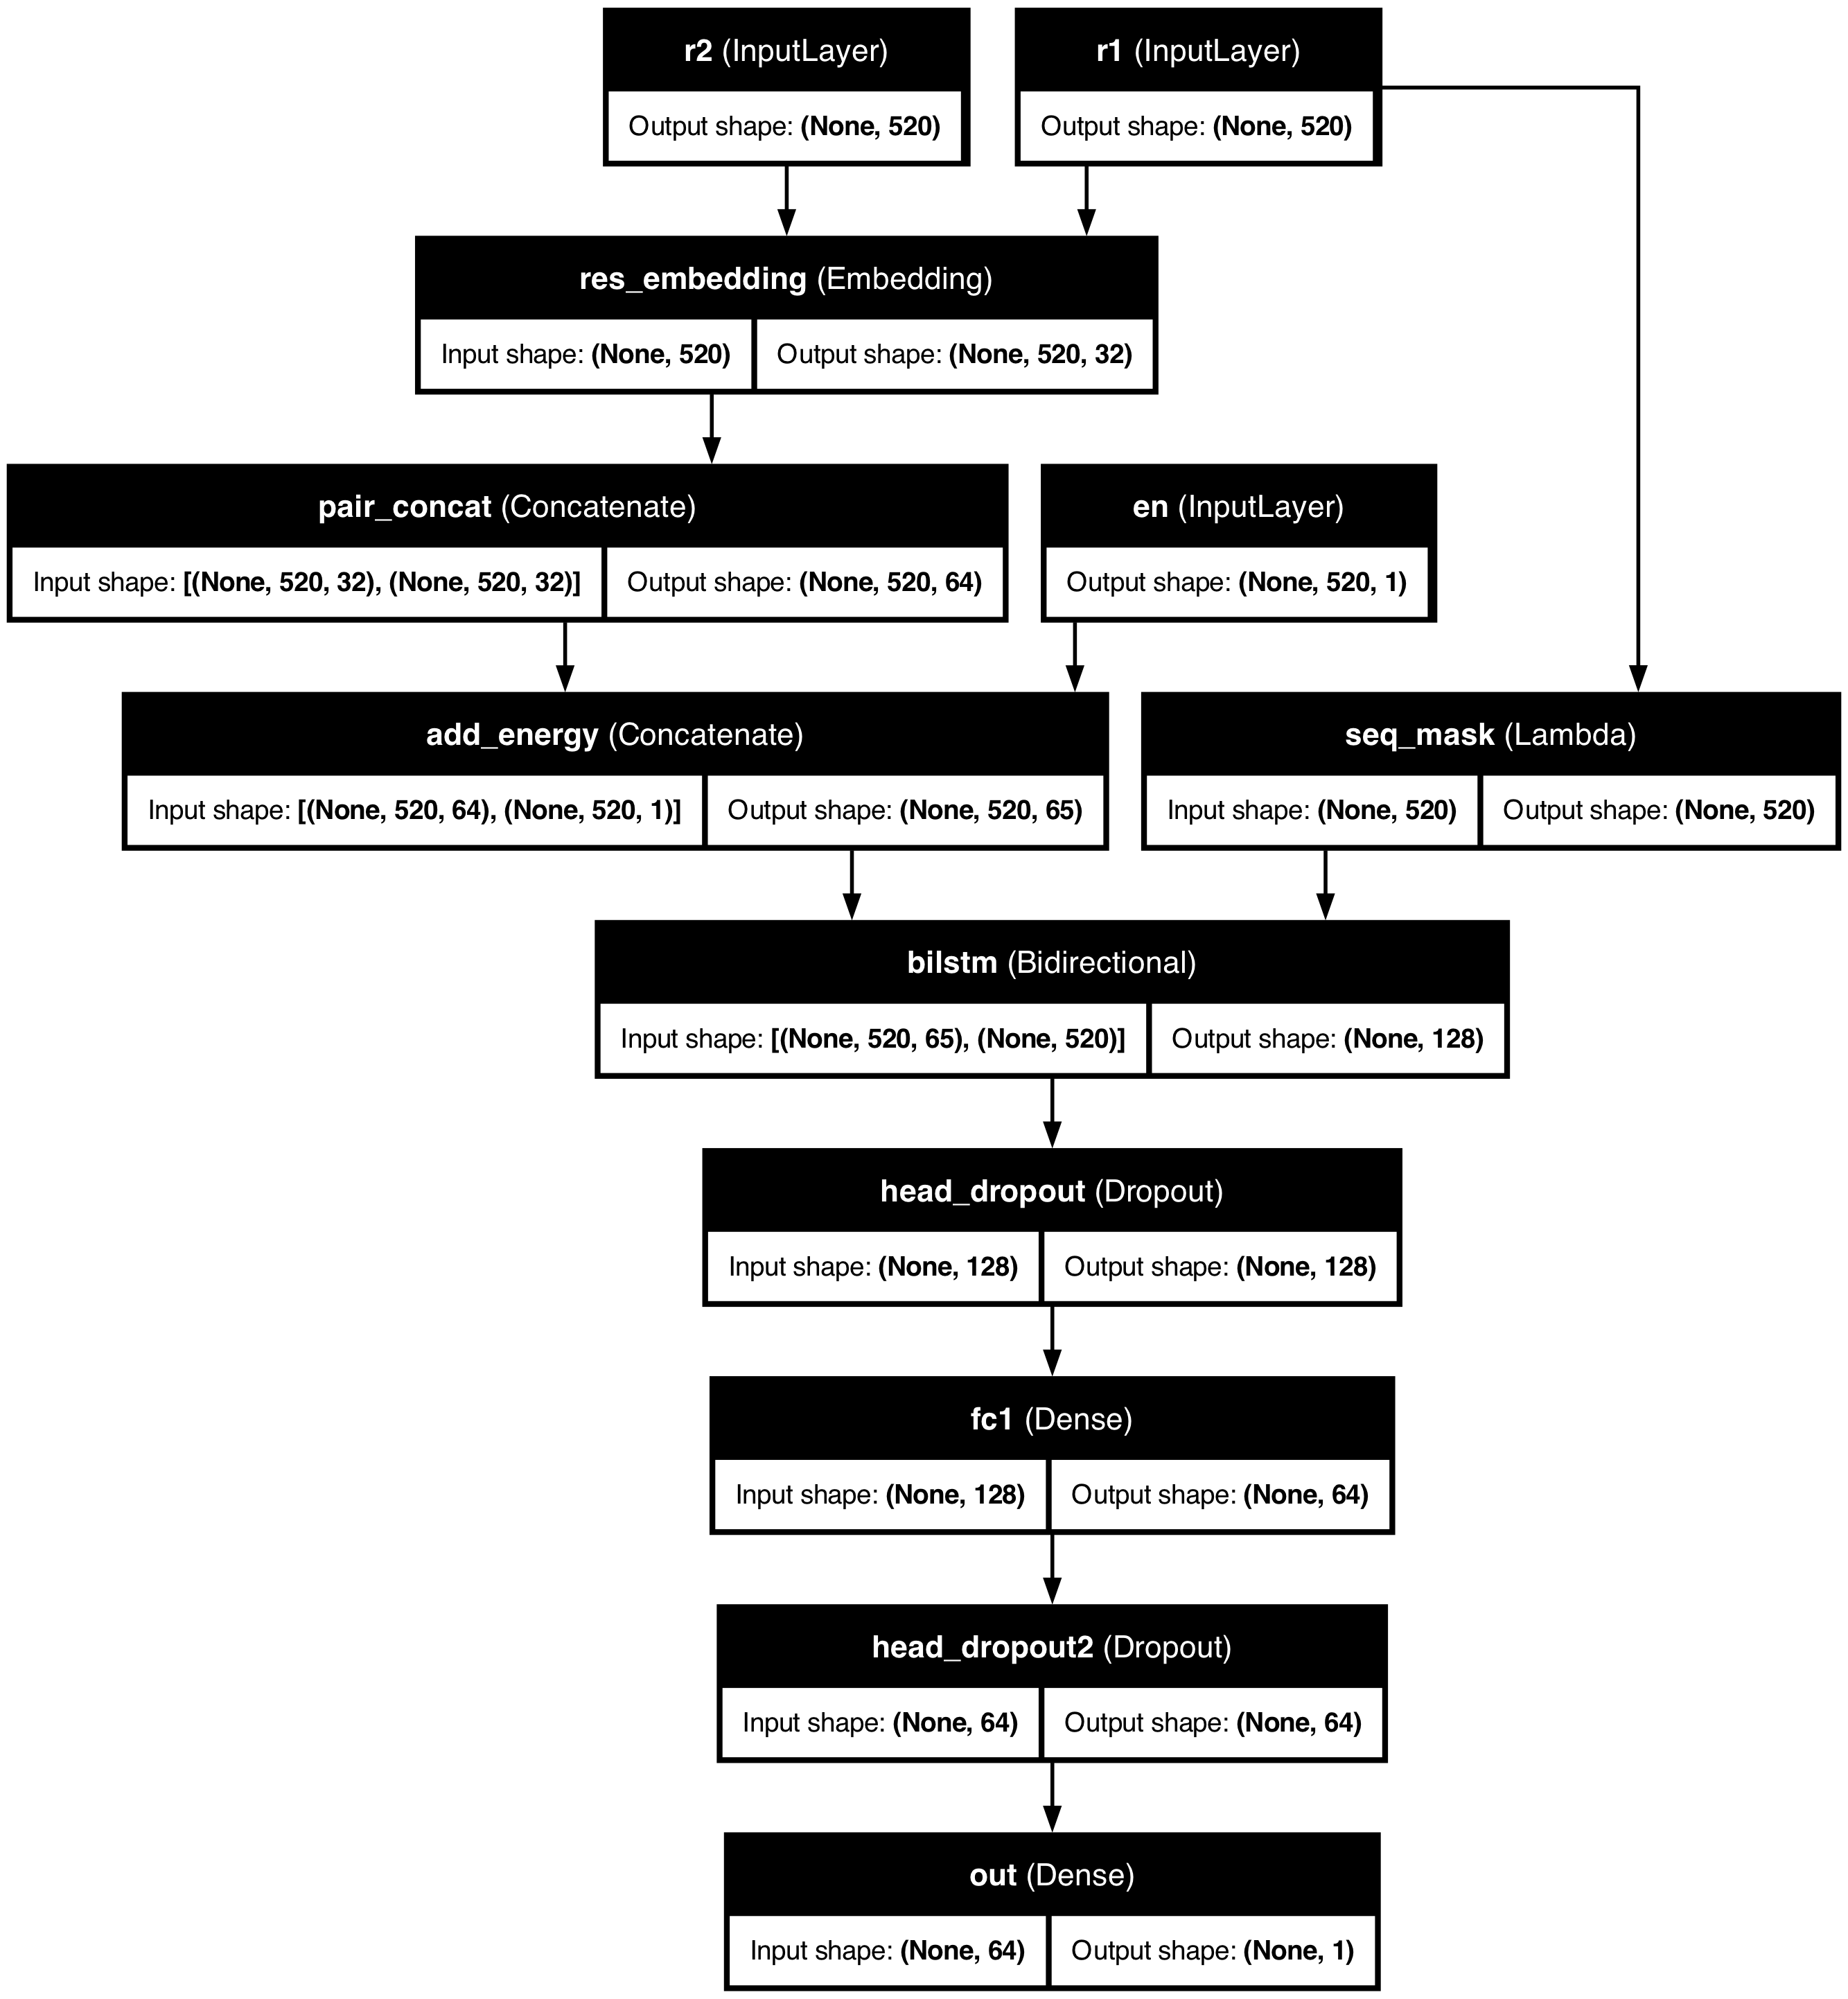

In [19]:
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

## Lets train it!!!

In [ ]:
# it was taking too long, so:
es  = EarlyStopping(monitor="val_auc", mode="max", patience=12, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", patience=4, factor=0.5, min_lr=1e-6, verbose=1)

history = model.fit(
    {"r1": r1_tr, "r2": r2_tr, "en": en_tr[..., None]},
    y_tr,
    validation_data=(
        {"r1": r1_va, "r2": r2_va, "en": en_va[..., None]},
        y_va
    ),
    epochs=200,
    batch_size=128,
    callbacks=[es, rlr],
    verbose=1,
    shuffle=True
)


# Did we do better than random at least????

In [78]:
test_loss, test_auc, test_acc = model.evaluate({"r1": r1_te, "r2": r2_te, "en": en_te[..., None]},y_te,verbose=0)

print(f"\nTest -> loss: {test_loss:.4f} | AUC: {test_auc:.4f} | acc: {test_acc:.4f}")

y_prob = model.predict({"r1": r1_te, "r2": r2_te, "en": en_te[..., None]}, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_te, y_prob))
print("Accuracy:", accuracy_score(y_te, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))
print("Classification report:\n", classification_report(y_te, y_pred, digits=4))


Test -> loss: 0.5011 | AUC: 0.8351 | acc: 0.7605
ROC AUC: 0.8350604180859836
Accuracy: 0.7604790419161677
Confusion matrix:
 [[112  55]
 [ 25 142]]
Classification report:
               precision    recall  f1-score   support

         0.0     0.8175    0.6707    0.7368       167
         1.0     0.7208    0.8503    0.7802       167

    accuracy                         0.7605       334
   macro avg     0.7692    0.7605    0.7585       334
weighted avg     0.7692    0.7605    0.7585       334



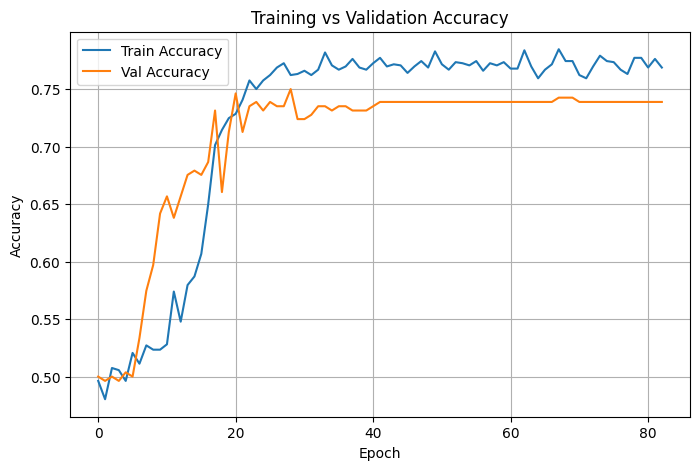

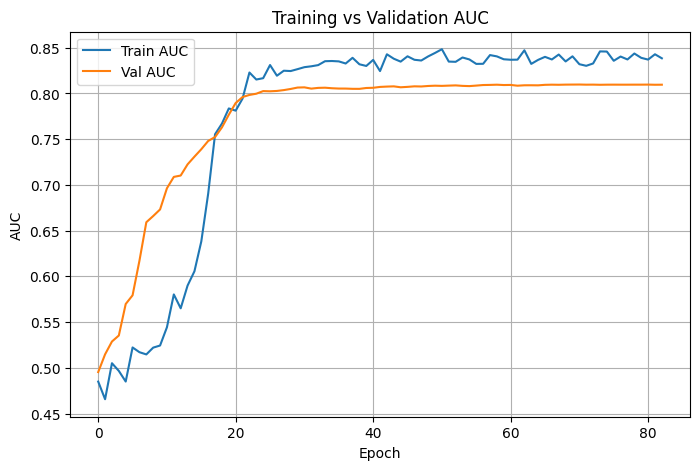

In [80]:
hist = history.history

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(hist["accuracy"], label="Train Accuracy")
plt.plot(hist["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC
plt.figure(figsize=(8,5))
plt.plot(hist["auc"], label="Train AUC")
plt.plot(hist["val_auc"], label="Val AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training vs Validation AUC")
plt.legend()
plt.grid(True)
plt.show()